# TRM Labs Analysis

## ARR Split Analysis ✓
- **Current Split**: Private 63.8% ($26.5M) vs Government 36.2% ($15.0M)
- **Trend**: Government share grew from 17.6% → 28.9% since 2023Q2

## False Positive Analysis ✓
- **By Alert Type**: Ransomware 6% (best) → Fraud Detection 19.3% (worst)
- **Model Improvements**: Fraud Detection -19.7pp, Sanctions -2.7pp; Compliance +6.5pp (degraded)

## NRR Analysis ✓
- **NRR**: 127.8% (excellent)
- **Expansion**: +$11.4M (+37.4%)
- **Churn**: -$2.9M (-9.5%)
- **Drivers**: Enterprise tiers expand most (44%), weak chain-expansion correlation (r=0.05)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import os

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (12, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})
COLORS = {'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
          'blue': '#73acfb', 'green': '#4ca86f', 'yellow': '#fec163'}

# Connect to TRM Labs database
engine = create_engine(os.environ['TRM_LABS_CONNECTION_URL'])

# Query ARR with sector information
query = text("""
SELECT 
    s.id, s.account_id, s.arr_usd, s.arr_at_start, s.start_date, s.status,
    a.org_name, a.sector,
    CASE 
        WHEN a.sector LIKE 'govt_%' THEN 'Government'
        ELSE 'Private Sector'
    END as segment
FROM subscriptions s
JOIN accounts a ON s.account_id = a.id
WHERE s.status = 'active'
""")

with engine.connect() as conn:
    df = pd.read_sql(query, conn)

df['start_date'] = pd.to_datetime(df['start_date'])
print(f"Active subscriptions: {len(df):,}")
print(f"Total current ARR: ${df['arr_usd'].sum():,.0f}")

Active subscriptions: 161
Total current ARR: $41,464,324


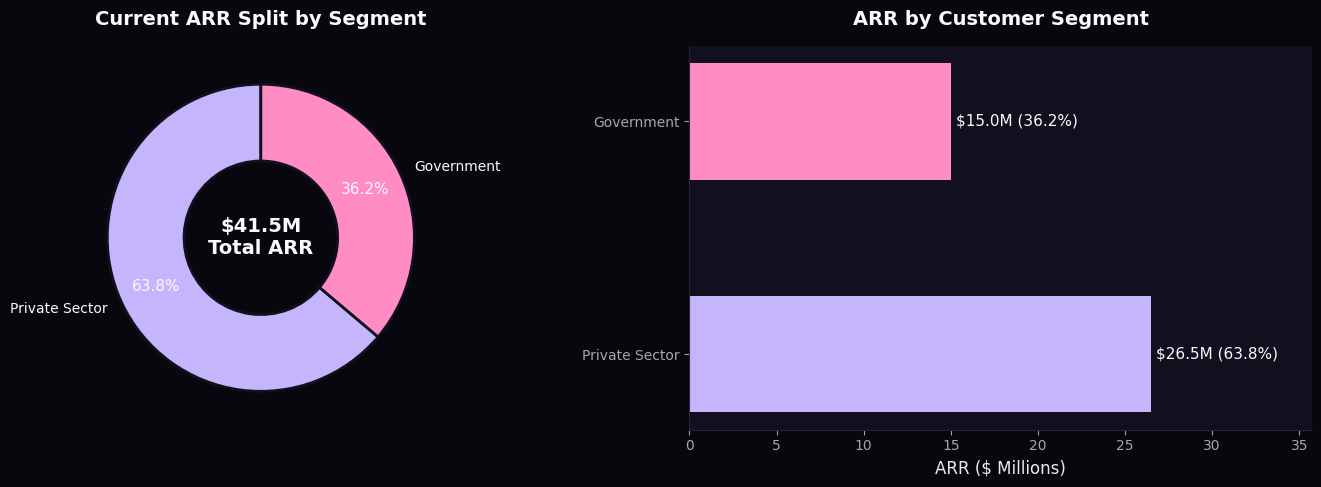


Segment                       ARR   Accounts     Avg Deal    Share
-----------------------------------------------------------------
Private Sector     $     26.47M         99 $      267K    63.8%
Government         $     15.00M         62 $      242K    36.2%


In [3]:
# Current ARR split by segment
segment_arr = df.groupby('segment')['arr_usd'].agg(['sum', 'count']).reset_index()
segment_arr.columns = ['Segment', 'ARR', 'Accounts']
segment_arr['Pct'] = segment_arr['ARR'] / segment_arr['ARR'].sum() * 100
segment_arr['Avg Deal'] = segment_arr['ARR'] / segment_arr['Accounts']
segment_arr = segment_arr.sort_values('ARR', ascending=False)

# Create side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Donut chart - ARR split
colors = [COLORS['primary'], COLORS['secondary']]
wedges, texts, autotexts = axes[0].pie(
    segment_arr['ARR'], labels=segment_arr['Segment'], autopct='%1.1f%%',
    colors=colors, startangle=90, pctdistance=0.75,
    wedgeprops={'width': 0.5, 'edgecolor': '#12101e', 'linewidth': 2}
)
for t in texts + autotexts:
    t.set_color('#FAFAFA')
axes[0].set_title('Current ARR Split by Segment', fontweight='bold', pad=15)

# Add center text
total_arr = segment_arr['ARR'].sum()
axes[0].text(0, 0, f'${total_arr/1e6:.1f}M\nTotal ARR', ha='center', va='center', 
             fontsize=14, fontweight='bold', color='#FAFAFA')

# Bar chart - ARR by segment
bars = axes[1].barh(segment_arr['Segment'], segment_arr['ARR']/1e6, color=colors, height=0.5)
axes[1].set_xlabel('ARR ($ Millions)')
axes[1].set_title('ARR by Customer Segment', fontweight='bold', pad=15)
for bar, pct in zip(bars, segment_arr['Pct']):
    axes[1].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'${bar.get_width():.1f}M ({pct:.1f}%)', va='center', fontsize=11, color='#FAFAFA')
axes[1].set_xlim(0, segment_arr['ARR'].max()/1e6 * 1.35)

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'Segment':<18} {'ARR':>14} {'Accounts':>10} {'Avg Deal':>12} {'Share':>8}")
print("-" * 65)
for _, row in segment_arr.iterrows():
    print(f"{row['Segment']:<18} ${row['ARR']/1e6:>10.2f}M {int(row['Accounts']):>10} ${row['Avg Deal']/1e3:>9.0f}K {row['Pct']:>7.1f}%")

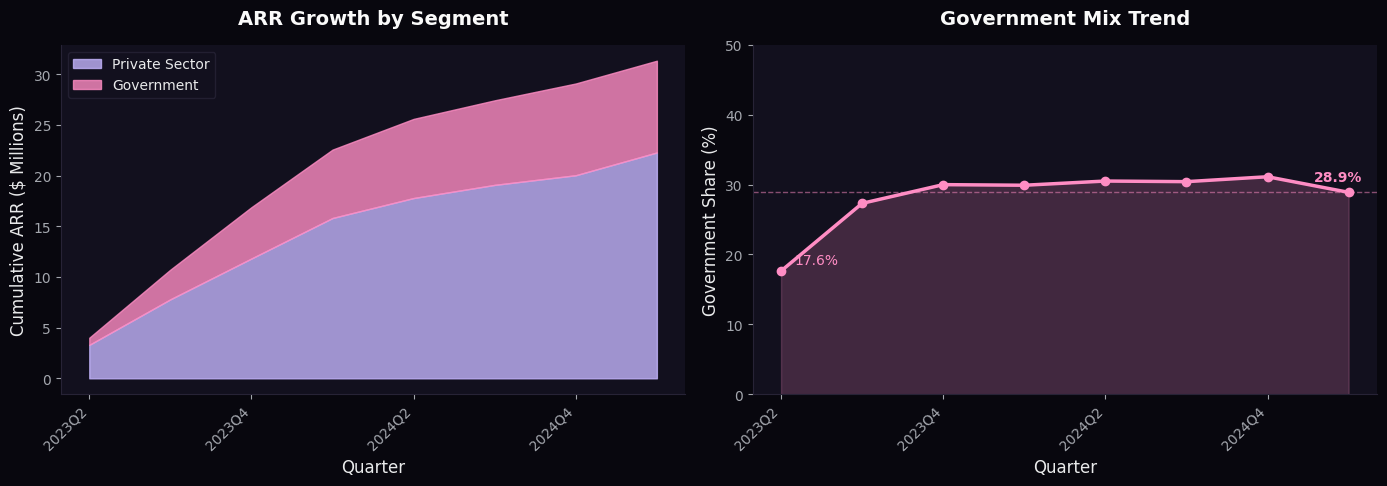


Government mix: 17.6% → 28.9% (Δ +11.3pp)
Latest quarter new ARR by segment:
  Private Sector: $2.25M
  Government: $0.00M


In [4]:
# Analyze ARR trend by segment over time (cohort by start date)
df['start_quarter'] = df['start_date'].dt.to_period('Q')

# Calculate cumulative ARR by segment over time
quarters = sorted(df['start_quarter'].unique())
trend_data = []

for q in quarters:
    mask = df['start_quarter'] <= q
    for seg in ['Government', 'Private Sector']:
        seg_arr = df[(mask) & (df['segment'] == seg)]['arr_at_start'].sum()
        trend_data.append({'Quarter': q, 'Segment': seg, 'Cumulative ARR': seg_arr})

trend_df = pd.DataFrame(trend_data)
trend_df['Quarter'] = trend_df['Quarter'].astype(str)

# Pivot for plotting
trend_pivot = trend_df.pivot(index='Quarter', columns='Segment', values='Cumulative ARR').fillna(0)
trend_pivot['Total'] = trend_pivot.sum(axis=1)
trend_pivot['Govt %'] = trend_pivot['Government'] / trend_pivot['Total'] * 100
trend_pivot['Private %'] = trend_pivot['Private Sector'] / trend_pivot['Total'] * 100

# Create trend visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stacked area chart - cumulative ARR by segment
x = range(len(trend_pivot))
axes[0].fill_between(x, 0, trend_pivot['Private Sector']/1e6, 
                     color=COLORS['primary'], alpha=0.8, label='Private Sector')
axes[0].fill_between(x, trend_pivot['Private Sector']/1e6, trend_pivot['Total']/1e6,
                     color=COLORS['secondary'], alpha=0.8, label='Government')
axes[0].set_xticks(x[::2])
axes[0].set_xticklabels(trend_pivot.index[::2], rotation=45, ha='right')
axes[0].set_xlabel('Quarter')
axes[0].set_ylabel('Cumulative ARR ($ Millions)')
axes[0].set_title('ARR Growth by Segment', fontweight='bold', pad=15)
axes[0].legend(loc='upper left', frameon=True)

# Line chart - Government share % over time
axes[1].plot(x, trend_pivot['Govt %'], color=COLORS['secondary'], linewidth=2.5, 
             marker='o', markersize=6, label='Government %')
axes[1].axhline(y=trend_pivot['Govt %'].iloc[-1], color=COLORS['secondary'], 
                linestyle='--', alpha=0.5, linewidth=1)
axes[1].fill_between(x, trend_pivot['Govt %'], alpha=0.2, color=COLORS['secondary'])
axes[1].set_xticks(x[::2])
axes[1].set_xticklabels(trend_pivot.index[::2], rotation=45, ha='right')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Government Share (%)')
axes[1].set_title('Government Mix Trend', fontweight='bold', pad=15)
axes[1].set_ylim(0, 50)

# Annotate start and end points
start_pct = trend_pivot['Govt %'].iloc[0]
end_pct = trend_pivot['Govt %'].iloc[-1]
axes[1].annotate(f'{start_pct:.1f}%', (0, start_pct), textcoords="offset points", 
                xytext=(10, 5), fontsize=10, color=COLORS['secondary'])
axes[1].annotate(f'{end_pct:.1f}%', (len(x)-1, end_pct), textcoords="offset points", 
                xytext=(-25, 8), fontsize=10, fontweight='bold', color=COLORS['secondary'])

plt.tight_layout()
plt.show()

# Summary stats
print(f"\nGovernment mix: {start_pct:.1f}% → {end_pct:.1f}% (Δ {end_pct - start_pct:+.1f}pp)")
print(f"Latest quarter new ARR by segment:")
latest_q = df['start_quarter'].max()
for seg in ['Private Sector', 'Government']:
    new_arr = df[(df['start_quarter'] == latest_q) & (df['segment'] == seg)]['arr_at_start'].sum()
    print(f"  {seg}: ${new_arr/1e6:.2f}M")

In [5]:
# Query alerts and model releases data
alerts_query = text("""
SELECT id, alert_type, severity, is_false_positive, model_version, created_at, amount_usd
FROM alert_events
""")

models_query = text("""
SELECT version, release_date, alert_types_covered, precision_score, recall_score, description
FROM model_releases
ORDER BY release_date
""")

with engine.connect() as conn:
    alerts_df = pd.read_sql(alerts_query, conn)
    models_df = pd.read_sql(models_query, conn)

alerts_df['created_at'] = pd.to_datetime(alerts_df['created_at'])
models_df['release_date'] = pd.to_datetime(models_df['release_date'])

print(f"Total alerts: {len(alerts_df):,}")
print(f"Model versions: {models_df['version'].nunique()}")
print(f"Alert types: {alerts_df['alert_type'].unique().tolist()}")

Total alerts: 25,000
Model versions: 18
Alert types: ['sanctions_screening', 'fraud_detection', 'compliance_alert', 'ransomware']


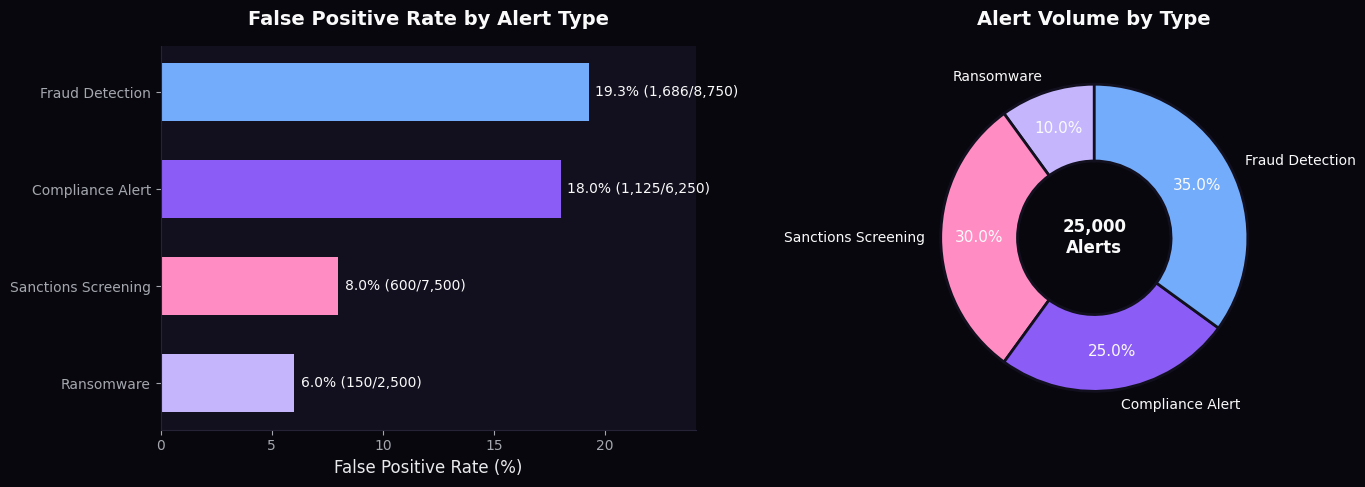


Alert Type                 Alerts    False Pos    FP Rate
----------------------------------------------------------
Fraud Detection             8,750        1,686      19.3%
Compliance Alert            6,250        1,125      18.0%
Sanctions Screening         7,500          600       8.0%
Ransomware                  2,500          150       6.0%


In [6]:
# False positive rate by alert type
fp_by_type = alerts_df.groupby('alert_type').agg(
    total_alerts=('id', 'count'),
    false_positives=('is_false_positive', 'sum')
).reset_index()
fp_by_type['fp_rate'] = fp_by_type['false_positives'] / fp_by_type['total_alerts'] * 100
fp_by_type = fp_by_type.sort_values('fp_rate', ascending=True)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart - FP rate by alert type
colors_list = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary'], COLORS['blue']]
bars = axes[0].barh(fp_by_type['alert_type'].str.replace('_', ' ').str.title(), 
                    fp_by_type['fp_rate'], color=colors_list, height=0.6)
axes[0].set_xlabel('False Positive Rate (%)')
axes[0].set_title('False Positive Rate by Alert Type', fontweight='bold', pad=15)
axes[0].set_xlim(0, fp_by_type['fp_rate'].max() * 1.25)

for bar, (_, row) in zip(bars, fp_by_type.iterrows()):
    axes[0].text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                f'{row["fp_rate"]:.1f}% ({int(row["false_positives"]):,}/{int(row["total_alerts"]):,})',
                va='center', fontsize=10, color='#FAFAFA')

# Pie chart showing alert volume distribution
wedges, texts, autotexts = axes[1].pie(
    fp_by_type['total_alerts'], labels=fp_by_type['alert_type'].str.replace('_', ' ').str.title(),
    autopct='%1.1f%%', colors=colors_list, startangle=90, pctdistance=0.75,
    wedgeprops={'width': 0.5, 'edgecolor': '#12101e', 'linewidth': 2}
)
for t in texts + autotexts:
    t.set_color('#FAFAFA')
axes[1].set_title('Alert Volume by Type', fontweight='bold', pad=15)
axes[1].text(0, 0, f'{len(alerts_df):,}\nAlerts', ha='center', va='center', 
             fontsize=12, fontweight='bold', color='#FAFAFA')

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'Alert Type':<22} {'Alerts':>10} {'False Pos':>12} {'FP Rate':>10}")
print("-" * 58)
for _, row in fp_by_type.sort_values('fp_rate', ascending=False).iterrows():
    print(f"{row['alert_type'].replace('_', ' ').title():<22} {int(row['total_alerts']):>10,} {int(row['false_positives']):>12,} {row['fp_rate']:>9.1f}%")

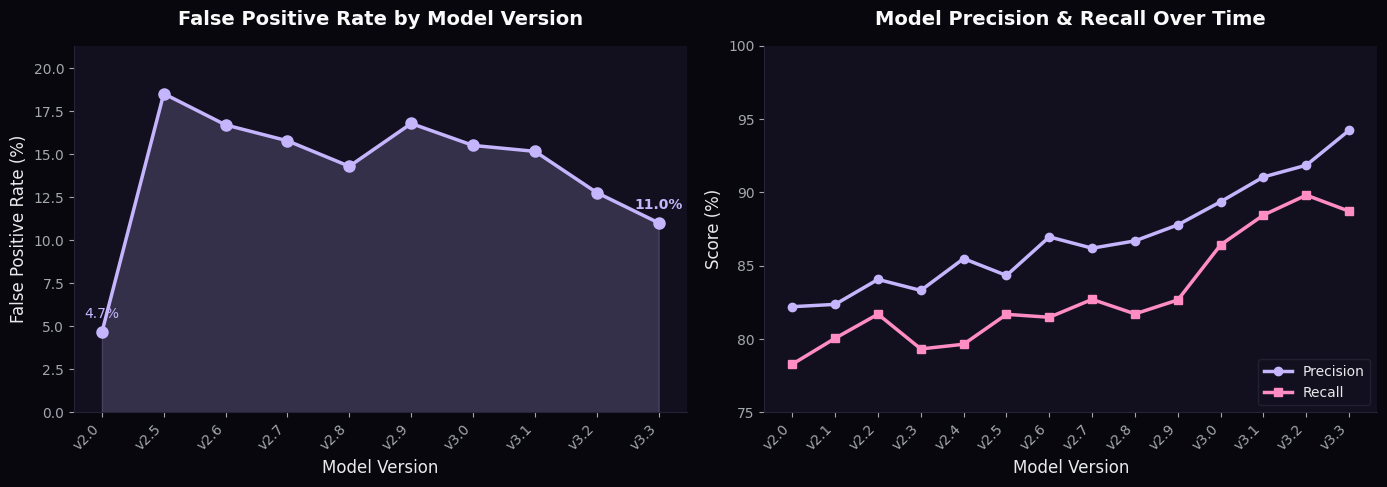


FP Rate Improvement: 4.7% → 11.0% (Δ +6.4pp, -137% reduction)
Precision: 82.2% → 94.2%
Recall: 78.3% → 88.7%


In [7]:
# FP rate by model version (major versions only for cleaner view)
alerts_df['major_version'] = alerts_df['model_version'].str.extract(r'(v\d+\.\d+)')[0]

fp_by_version = alerts_df.groupby('major_version').agg(
    total_alerts=('id', 'count'),
    false_positives=('is_false_positive', 'sum')
).reset_index()
fp_by_version['fp_rate'] = fp_by_version['false_positives'] / fp_by_version['total_alerts'] * 100

# Get release dates for versions
version_dates = models_df.groupby(models_df['version'].str.extract(r'(v\d+\.\d+)')[0])['release_date'].min().reset_index()
version_dates.columns = ['major_version', 'release_date']
fp_by_version = fp_by_version.merge(version_dates, on='major_version', how='left')
fp_by_version = fp_by_version.sort_values('release_date')

# Create trend visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line chart - FP rate over model versions
x = range(len(fp_by_version))
axes[0].plot(x, fp_by_version['fp_rate'], color=COLORS['primary'], linewidth=2.5, 
             marker='o', markersize=8, zorder=3)
axes[0].fill_between(x, fp_by_version['fp_rate'], alpha=0.2, color=COLORS['primary'])
axes[0].set_xticks(x)
axes[0].set_xticklabels(fp_by_version['major_version'], rotation=45, ha='right')
axes[0].set_xlabel('Model Version')
axes[0].set_ylabel('False Positive Rate (%)')
axes[0].set_title('False Positive Rate by Model Version', fontweight='bold', pad=15)
axes[0].set_ylim(0, fp_by_version['fp_rate'].max() * 1.15)

# Annotate improvement
start_fp = fp_by_version['fp_rate'].iloc[0]
end_fp = fp_by_version['fp_rate'].iloc[-1]
axes[0].annotate(f'{start_fp:.1f}%', (0, start_fp), textcoords="offset points", 
                xytext=(0, 10), ha='center', fontsize=10, color=COLORS['primary'])
axes[0].annotate(f'{end_fp:.1f}%', (len(x)-1, end_fp), textcoords="offset points", 
                xytext=(0, 10), ha='center', fontsize=10, fontweight='bold', color=COLORS['primary'])

# Model precision/recall trend from model_releases
models_df['major_version'] = models_df['version'].str.extract(r'(v\d+\.\d+)')[0]
model_metrics = models_df.groupby('major_version').agg(
    precision=('precision_score', 'max'),
    recall=('recall_score', 'max'),
    release_date=('release_date', 'min')
).reset_index().sort_values('release_date')

x2 = range(len(model_metrics))
axes[1].plot(x2, model_metrics['precision'] * 100, color=COLORS['primary'], linewidth=2.5, 
             marker='o', markersize=6, label='Precision')
axes[1].plot(x2, model_metrics['recall'] * 100, color=COLORS['secondary'], linewidth=2.5, 
             marker='s', markersize=6, label='Recall')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(model_metrics['major_version'], rotation=45, ha='right')
axes[1].set_xlabel('Model Version')
axes[1].set_ylabel('Score (%)')
axes[1].set_title('Model Precision & Recall Over Time', fontweight='bold', pad=15)
axes[1].legend(loc='lower right', frameon=True)
axes[1].set_ylim(75, 100)

plt.tight_layout()
plt.show()

# Improvement summary
fp_improvement = start_fp - end_fp
pct_improvement = fp_improvement / start_fp * 100
print(f"\nFP Rate Improvement: {start_fp:.1f}% → {end_fp:.1f}% (Δ {-fp_improvement:+.1f}pp, {pct_improvement:.0f}% reduction)")
print(f"Precision: {model_metrics['precision'].iloc[0]*100:.1f}% → {model_metrics['precision'].iloc[-1]*100:.1f}%")
print(f"Recall: {model_metrics['recall'].iloc[0]*100:.1f}% → {model_metrics['recall'].iloc[-1]*100:.1f}%")

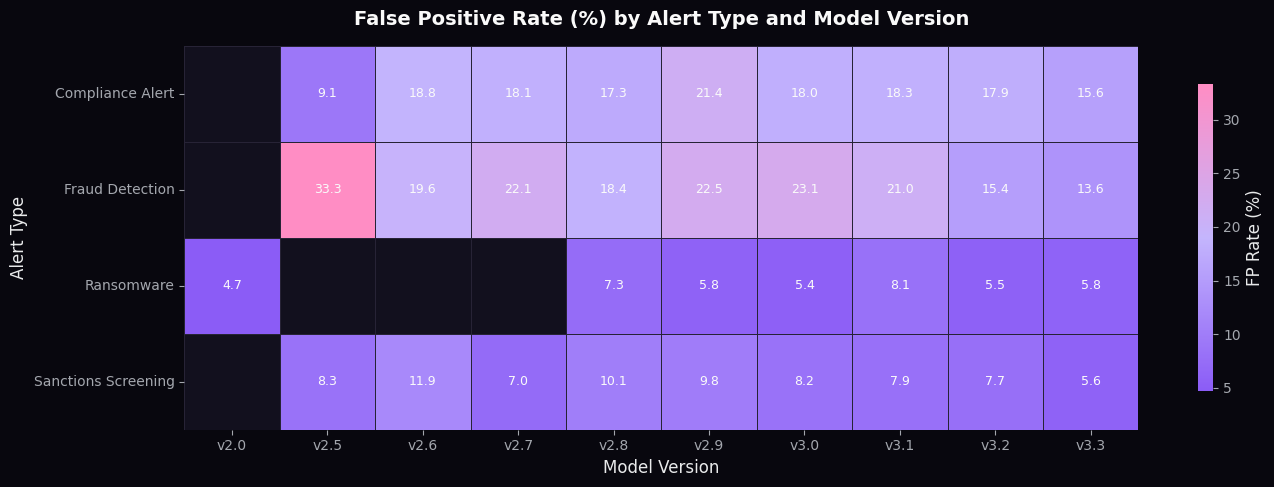


FP Rate Change by Alert Type (earliest → latest available version):
------------------------------------------------------------
Compliance Alert      :   9.1% →  15.6% (+6.5pp)
Fraud Detection       :  33.3% →  13.6% (-19.7pp)
Ransomware            :   4.7% →   5.8% (+1.2pp)
Sanctions Screening   :   8.3% →   5.6% (-2.7pp)


In [8]:
# Investigate: FP rate by version AND alert type to understand the trend
fp_by_version_type = alerts_df.groupby(['major_version', 'alert_type']).agg(
    total=('id', 'count'),
    fps=('is_false_positive', 'sum')
).reset_index()
fp_by_version_type['fp_rate'] = fp_by_version_type['fps'] / fp_by_version_type['total'] * 100
fp_by_version_type = fp_by_version_type.merge(version_dates, on='major_version', how='left')
fp_by_version_type = fp_by_version_type.sort_values('release_date')

# Pivot for heatmap
fp_pivot = fp_by_version_type.pivot(index='alert_type', columns='major_version', values='fp_rate')

# Reorder columns by release date
version_order = fp_by_version[fp_by_version['major_version'].isin(fp_pivot.columns)].sort_values('release_date')['major_version'].tolist()
fp_pivot = fp_pivot[version_order]

# Create heatmap showing FP rate by alert type and version
fig, ax = plt.subplots(figsize=(14, 5))

from matplotlib.colors import LinearSegmentedColormap
# Reversed colormap: low FP (good) = purple, high FP (bad) = pink
sp_cmap = LinearSegmentedColormap.from_list('signalpilot_r', ['#8b5cf6', '#c4b5fd', '#ff8dc4'])

import seaborn as sns
sns.heatmap(fp_pivot, annot=True, fmt='.1f', cmap=sp_cmap, ax=ax,
            cbar_kws={'label': 'FP Rate (%)', 'shrink': 0.8},
            annot_kws={'size': 9, 'color': '#FAFAFA'}, linewidths=0.5, linecolor='#272336')

ax.set_xlabel('Model Version')
ax.set_ylabel('Alert Type')
ax.set_title('False Positive Rate (%) by Alert Type and Model Version', fontweight='bold', pad=15)
ax.set_yticklabels([t.get_text().replace('_', ' ').title() for t in ax.get_yticklabels()], rotation=0)

plt.tight_layout()
plt.show()

# Summary: Look at improvement within each alert type
print("\nFP Rate Change by Alert Type (earliest → latest available version):")
print("-" * 60)
for alert_type in fp_pivot.index:
    row = fp_pivot.loc[alert_type].dropna()
    if len(row) >= 2:
        first_val = row.iloc[0]
        last_val = row.iloc[-1]
        change = last_val - first_val
        print(f"{alert_type.replace('_', ' ').title():<22}: {first_val:>5.1f}% → {last_val:>5.1f}% ({change:+.1f}pp)")

In [9]:
# Query full subscription and chain coverage data for NRR analysis
subs_query = text("""
SELECT s.account_id, s.plan_name, s.arr_usd, s.arr_at_start, s.start_date, s.status,
       a.org_name, a.sector
FROM subscriptions s
LEFT JOIN accounts a ON s.account_id = a.id
""")

chains_query = text("""
SELECT account_id, chain_name, added_date, monitoring_status
FROM chain_coverage
""")

with engine.connect() as conn:
    subs_df = pd.read_sql(subs_query, conn)
    chains_df = pd.read_sql(chains_query, conn)

subs_df['start_date'] = pd.to_datetime(subs_df['start_date'])
chains_df['added_date'] = pd.to_datetime(chains_df['added_date'])

print(f"Subscriptions: {len(subs_df):,} | Chains monitored: {len(chains_df):,}")
print(f"Plan types: {subs_df['plan_name'].nunique()} | Chains available: {chains_df['chain_name'].nunique()}")

Subscriptions: 180 | Chains monitored: 720
Plan types: 6 | Chains available: 15


In [10]:
# Calculate NRR components
# Filter to accounts with at least 6 months tenure for meaningful NRR
cutoff_date = pd.Timestamp('2024-09-01')
mature_subs = subs_df[subs_df['start_date'] < cutoff_date].copy()

# NRR calculation: Current ARR from cohort / Starting ARR of cohort
mature_subs['expansion'] = (mature_subs['arr_usd'] - mature_subs['arr_at_start']).clip(lower=0)
mature_subs['contraction'] = (mature_subs['arr_at_start'] - mature_subs['arr_usd']).clip(lower=0)
mature_subs['churned_arr'] = mature_subs.apply(
    lambda x: x['arr_at_start'] if x['status'] == 'churned' else 0, axis=1
)

# NRR by status
starting_arr = mature_subs['arr_at_start'].sum()
current_arr = mature_subs[mature_subs['status'] == 'active']['arr_usd'].sum()
expansion = mature_subs['expansion'].sum()
contraction = mature_subs['contraction'].sum()
churned = mature_subs['churned_arr'].sum()

nrr = (starting_arr + expansion - contraction - churned) / starting_arr * 100

print(f"=== Net Revenue Retention (accounts started before Sep 2024) ===")
print(f"Cohort: {len(mature_subs)} accounts")
print(f"\nStarting ARR:   ${starting_arr:>12,.0f}")
print(f"+ Expansion:    ${expansion:>12,.0f}  (+{expansion/starting_arr*100:.1f}%)")
print(f"- Contraction:  ${contraction:>12,.0f}  (-{contraction/starting_arr*100:.1f}%)")
print(f"- Churn:        ${churned:>12,.0f}  (-{churned/starting_arr*100:.1f}%)")
print(f"{'='*45}")
print(f"NRR:            {nrr:>13.1f}%")

=== Net Revenue Retention (accounts started before Sep 2024) ===
Cohort: 156 accounts

Starting ARR:   $  30,488,246
+ Expansion:    $  11,400,348  (+37.4%)
- Contraction:  $       3,926  (-0.0%)
- Churn:        $   2,906,036  (-9.5%)
NRR:                    127.8%


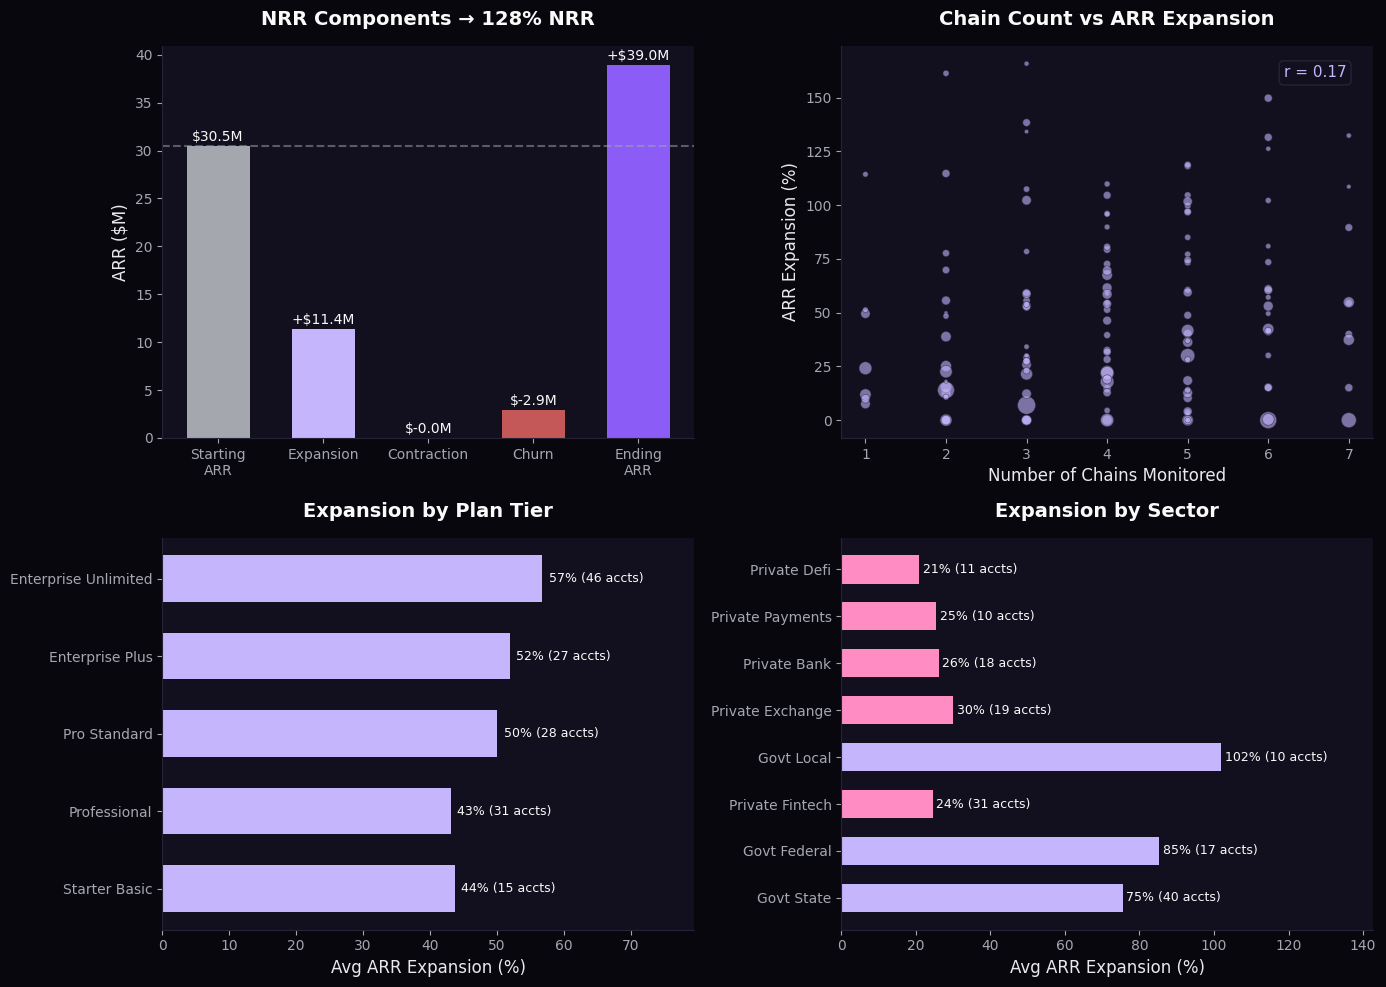

In [12]:
# Analyze expansion drivers
# 1. Chain expansion correlation
chains_per_account = chains_df.groupby('account_id').size().reset_index(name='chain_count')
mature_with_chains = mature_subs.merge(chains_per_account, on='account_id', how='left')
mature_with_chains['chain_count'] = mature_with_chains['chain_count'].fillna(0)
mature_with_chains['pct_expansion'] = (mature_with_chains['expansion'] / mature_with_chains['arr_at_start'] * 100).replace([float('inf')], 0)

# 2. Plan tier analysis
plan_order = ['starter_basic', 'professional', 'pro_standard', 'enterprise_plus', 'enterprise_unlimited', 'government_pro']
plan_expansion = mature_with_chains.groupby('plan_name').agg(
    accounts=('account_id', 'count'),
    total_expansion=('expansion', 'sum'),
    avg_expansion_pct=('pct_expansion', 'mean'),
    avg_chains=('chain_count', 'mean')
).reindex([p for p in plan_order if p in mature_with_chains['plan_name'].values])

# 3. Sector analysis
sector_expansion = mature_with_chains.groupby('sector').agg(
    accounts=('account_id', 'count'),
    total_expansion=('expansion', 'sum'),
    avg_expansion_pct=('pct_expansion', 'mean'),
    avg_chains=('chain_count', 'mean')
).sort_values('total_expansion', ascending=False)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. NRR waterfall components
components = ['Starting\nARR', 'Expansion', 'Contraction', 'Churn', 'Ending\nARR']
values = [starting_arr/1e6, expansion/1e6, -contraction/1e6, -churned/1e6, 
          (starting_arr + expansion - contraction - churned)/1e6]
colors_wf = ['#a4a7ae', COLORS['primary'], COLORS['secondary'], '#c45757', COLORS['tertiary']]

bars = axes[0,0].bar(components, [abs(v) for v in values], color=colors_wf, width=0.6)
for bar, val in zip(bars, values):
    sign = '+' if val > 0 and bar.get_x() > 0.5 else ''
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{sign}${val:.1f}M', ha='center', fontsize=10, color='#FAFAFA')
axes[0,0].set_ylabel('ARR ($M)')
axes[0,0].set_title(f'NRR Components → {nrr:.0f}% NRR', fontweight='bold', pad=15)
axes[0,0].axhline(y=starting_arr/1e6, color='#a4a7ae', linestyle='--', alpha=0.5)

# 2. Chains vs Expansion scatter
scatter_data = mature_with_chains[mature_with_chains['status'] == 'active']
axes[0,1].scatter(scatter_data['chain_count'], scatter_data['pct_expansion'], 
                  alpha=0.6, color=COLORS['primary'], s=scatter_data['arr_at_start']/5000, 
                  edgecolors='#272336', linewidths=0.5)
axes[0,1].set_xlabel('Number of Chains Monitored')
axes[0,1].set_ylabel('ARR Expansion (%)')
axes[0,1].set_title('Chain Count vs ARR Expansion', fontweight='bold', pad=15)

# Add correlation
corr = scatter_data['chain_count'].corr(scatter_data['pct_expansion'])
axes[0,1].text(0.95, 0.95, f'r = {corr:.2f}', transform=axes[0,1].transAxes,
               ha='right', va='top', fontsize=11, color=COLORS['primary'],
               bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336'))

# 3. Expansion by plan tier
bars = axes[1,0].barh(plan_expansion.index.str.replace('_', ' ').str.title(), 
                      plan_expansion['avg_expansion_pct'], color=COLORS['primary'], height=0.6)
for bar, (idx, row) in zip(bars, plan_expansion.iterrows()):
    axes[1,0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                   f'{row["avg_expansion_pct"]:.0f}% ({int(row["accounts"])} accts)',
                   va='center', fontsize=9, color='#FAFAFA')
axes[1,0].set_xlabel('Avg ARR Expansion (%)')
axes[1,0].set_title('Expansion by Plan Tier', fontweight='bold', pad=15)
axes[1,0].set_xlim(0, plan_expansion['avg_expansion_pct'].max() * 1.4)

# 4. Expansion by sector
sector_colors = [COLORS['primary'] if 'gov' in s else COLORS['secondary'] for s in sector_expansion.index]
bars = axes[1,1].barh(sector_expansion.index.str.replace('_', ' ').str.title(), 
                      sector_expansion['avg_expansion_pct'], color=sector_colors, height=0.6)
for bar, (idx, row) in zip(bars, sector_expansion.iterrows()):
    axes[1,1].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                   f'{row["avg_expansion_pct"]:.0f}% ({int(row["accounts"])} accts)',
                   va='center', fontsize=9, color='#FAFAFA')
axes[1,1].set_xlabel('Avg ARR Expansion (%)')
axes[1,1].set_title('Expansion by Sector', fontweight='bold', pad=15)
axes[1,1].set_xlim(0, sector_expansion['avg_expansion_pct'].max() * 1.4)

plt.tight_layout()
plt.show()

In [13]:
# Query full transaction volume data
txn_query = text("""
SELECT t.month, t.account_id, t.txn_count, t.total_cost_usd, t.cost_per_txn, t.chain,
       a.sector, a.org_name
FROM transaction_volume t
LEFT JOIN accounts a ON t.account_id = a.id
WHERE t.chain = 'all'  -- Aggregate per account
ORDER BY t.month
""")

with engine.connect() as conn:
    txn_df = pd.read_sql(txn_query, conn)

txn_df['month'] = pd.to_datetime(txn_df['month'])
txn_df['txn_count'] = txn_df['txn_count'].astype(float)

# Monthly aggregates
monthly = txn_df.groupby('month').agg(
    total_txns=('txn_count', 'sum'),
    total_cost=('total_cost_usd', 'sum'),
    accounts=('account_id', 'nunique'),
    avg_cost_per_txn=('cost_per_txn', 'mean')
).reset_index()

monthly['txns_billions'] = monthly['total_txns'] / 1e9
monthly['cost_per_million'] = monthly['total_cost'] / (monthly['total_txns'] / 1e6)

print(f"Transaction monitoring data: {txn_df['month'].min().strftime('%b %Y')} to {txn_df['month'].max().strftime('%b %Y')}")
print(f"Total transactions monitored: {txn_df['txn_count'].sum()/1e9:.2f}B")
print(f"Active accounts with volume: {txn_df['account_id'].nunique()}")

Transaction monitoring data: May 2023 to Mar 2025
Total transactions monitored: 5.08B
Active accounts with volume: 180


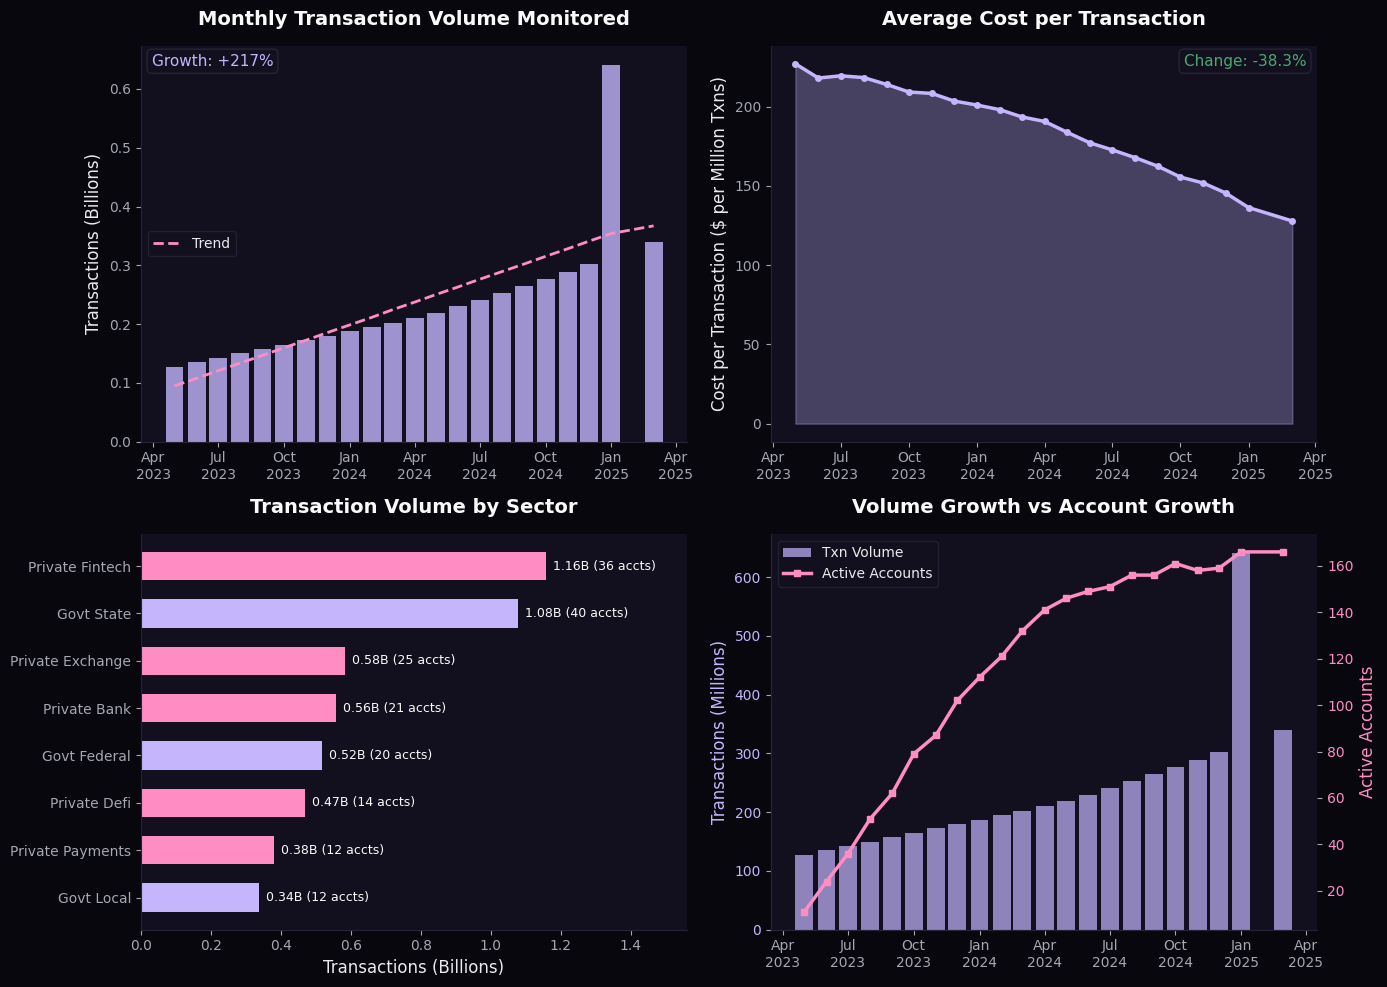


TRANSACTION MONITORING SUMMARY
Latest month: 340M transactions
Avg cost/txn: $127.80 per million txns
Volume growth (Q1 vs latest Q): +217%
Cost trend: -38.3%


In [14]:
# Visualize transaction volume and cost trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Monthly transaction volume
ax1 = axes[0, 0]
ax1.bar(monthly['month'], monthly['txns_billions'], color=COLORS['primary'], width=25, alpha=0.8)
ax1.set_ylabel('Transactions (Billions)')
ax1.set_title('Monthly Transaction Volume Monitored', fontweight='bold', pad=15)
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))

# Add trend line
z = np.polyfit(range(len(monthly)), monthly['txns_billions'], 1)
p = np.poly1d(z)
ax1.plot(monthly['month'], p(range(len(monthly))), '--', color=COLORS['secondary'], linewidth=2, label='Trend')
ax1.legend()

# Growth annotation
first_q = monthly.head(3)['txns_billions'].mean()
last_q = monthly.tail(3)['txns_billions'].mean()
growth = (last_q / first_q - 1) * 100
ax1.text(0.02, 0.98, f'Growth: +{growth:.0f}%', transform=ax1.transAxes,
         va='top', fontsize=11, color=COLORS['primary'],
         bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336'))

# 2. Cost per transaction trend
ax2 = axes[0, 1]
ax2.plot(monthly['month'], monthly['avg_cost_per_txn'] * 1e6, color=COLORS['primary'], linewidth=2.5, marker='o', markersize=4)
ax2.set_ylabel('Cost per Transaction ($ per Million Txns)')
ax2.set_title('Average Cost per Transaction', fontweight='bold', pad=15)
ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))

# Fill area
ax2.fill_between(monthly['month'], monthly['avg_cost_per_txn'] * 1e6, alpha=0.3, color=COLORS['primary'])

# Cost reduction annotation
first_cost = monthly.head(3)['avg_cost_per_txn'].mean() * 1e6
last_cost = monthly.tail(3)['avg_cost_per_txn'].mean() * 1e6
cost_change = (last_cost / first_cost - 1) * 100
ax2.text(0.98, 0.98, f'Change: {cost_change:+.1f}%', transform=ax2.transAxes,
         va='top', ha='right', fontsize=11, color='#4ca86f' if cost_change < 0 else '#c45757',
         bbox=dict(boxstyle='round', facecolor='#12101e', edgecolor='#272336'))

# 3. Volume by sector
sector_vol = txn_df.groupby('sector').agg(
    total_txns=('txn_count', 'sum'),
    accounts=('account_id', 'nunique')
).sort_values('total_txns', ascending=True)

sector_colors = [COLORS['primary'] if 'gov' in s else COLORS['secondary'] for s in sector_vol.index]
bars = axes[1, 0].barh(sector_vol.index.str.replace('_', ' ').str.title(), 
                        sector_vol['total_txns'] / 1e9, color=sector_colors, height=0.6)
for bar, (idx, row) in zip(bars, sector_vol.iterrows()):
    axes[1, 0].text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{row["total_txns"]/1e9:.2f}B ({int(row["accounts"])} accts)',
                    va='center', fontsize=9, color='#FAFAFA')
axes[1, 0].set_xlabel('Transactions (Billions)')
axes[1, 0].set_title('Transaction Volume by Sector', fontweight='bold', pad=15)
axes[1, 0].set_xlim(0, sector_vol['total_txns'].max() / 1e9 * 1.35)

# 4. Volume growth by month with account count overlay
ax4 = axes[1, 1]
ax4.bar(monthly['month'], monthly['total_txns'] / 1e6, color=COLORS['primary'], width=25, alpha=0.7, label='Txn Volume')
ax4.set_ylabel('Transactions (Millions)', color=COLORS['primary'])
ax4.set_xlabel('')
ax4.tick_params(axis='y', labelcolor=COLORS['primary'])

ax4_twin = ax4.twinx()
ax4_twin.plot(monthly['month'], monthly['accounts'], color=COLORS['secondary'], linewidth=2.5, marker='s', markersize=5, label='Active Accounts')
ax4_twin.set_ylabel('Active Accounts', color=COLORS['secondary'])
ax4_twin.tick_params(axis='y', labelcolor=COLORS['secondary'])

ax4.set_title('Volume Growth vs Account Growth', fontweight='bold', pad=15)
ax4.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))

# Combined legend
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Summary stats
print(f"\n{'='*50}")
print(f"TRANSACTION MONITORING SUMMARY")
print(f"{'='*50}")
print(f"Latest month: {monthly.iloc[-1]['total_txns']/1e6:,.0f}M transactions")
print(f"Avg cost/txn: ${monthly.iloc[-1]['avg_cost_per_txn']*1e6:.2f} per million txns")
print(f"Volume growth (Q1 vs latest Q): +{growth:.0f}%")
print(f"Cost trend: {cost_change:+.1f}%")